In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('../input/delhiecmu/Dataset.csv')
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.set_index('Date',inplace=True)
df.head()

,dayofweek,tempmax,tempmin,temp,feelslike,cloudcover,dew,humidity,solarenergy,sunrise,sunset,Un-Restricted Demand,Max Demand Met (MW),Energy Met (MU)
Date,,,,,,,,,,,,,,
2023-01-01,6,20.1,7.9,13.4,13.3,24.0,9.6,79.8,12.5,2023-01-01T07:13:58,2023-01-01T17:35:09,4614,4614,73.7
2023-01-02,0,17.0,9.0,12.4,12.4,18.1,10.3,87.9,13.0,2023-01-02T07:14:14,2023-01-02T17:35:50,4635,4635,78.2
2023-01-03,1,15.3,7.9,11.2,11.0,22.9,8.7,85.6,13.1,2023-01-03T07:14:27,2023-01-03T17:36:33,4890,4890,81.4
2023-01-04,2,15.0,6.9,9.6,9.0,12.9,7.9,90.1,13.2,2023-01-04T07:14:39,2023-01-04T17:37:16,5163,5127,85.6
2023-01-05,3,17.0,5.8,9.7,9.4,25.0,6.1,83.0,13.4,2023-01-05T07:14:50,2023-01-05T17:38:00,5247,5247,85.6


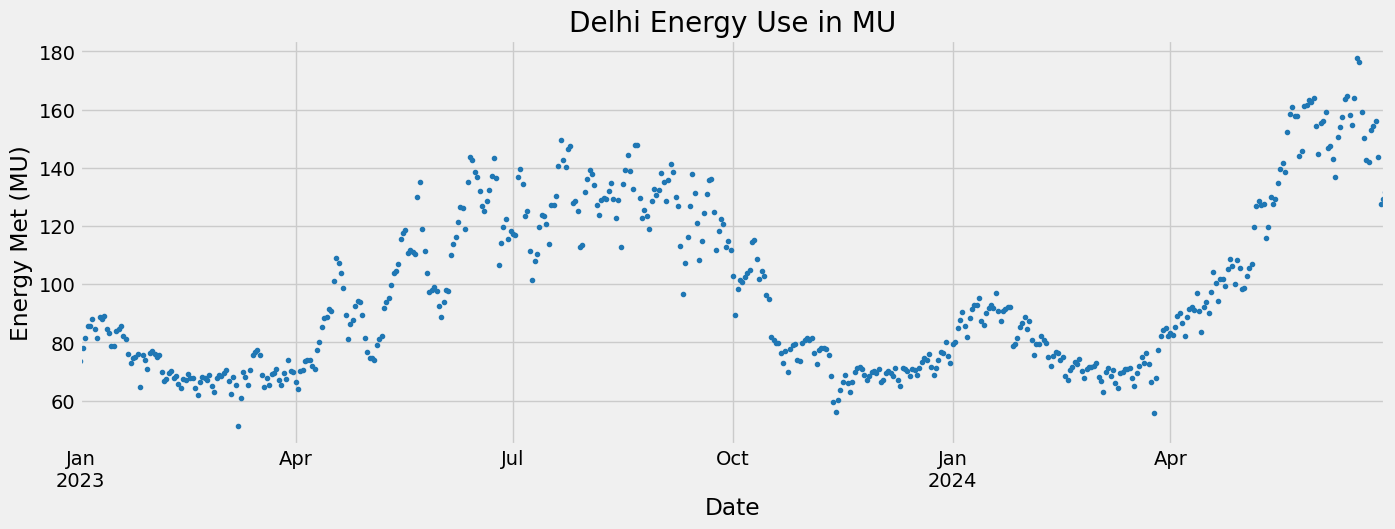

In [3]:
df['Energy Met (MU)'].plot(style='.',
                      figsize=(15,5),
                      color=color_pal[0],
                      title='Delhi Energy Use in MU')
plt.xlabel('Date')
plt.ylabel('Energy Met (MU)')
plt.show()

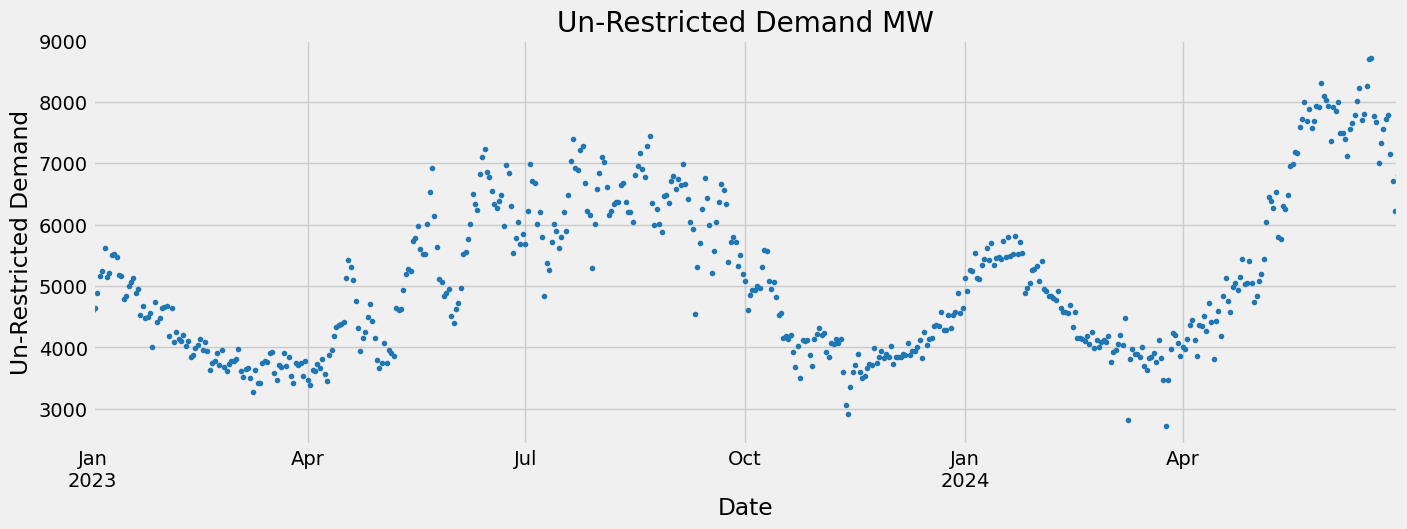

In [4]:
df['Un-Restricted Demand'].plot(style='.',
                      figsize=(15,5),
                      color=color_pal[0],
                      title='Un-Restricted Demand MW')
plt.xlabel('Date')
plt.ylabel('Un-Restricted Demand')
plt.show()

# Train/Test Split

<Axes: title={'center': 'Data Train/Test Split'}, xlabel='Date'>

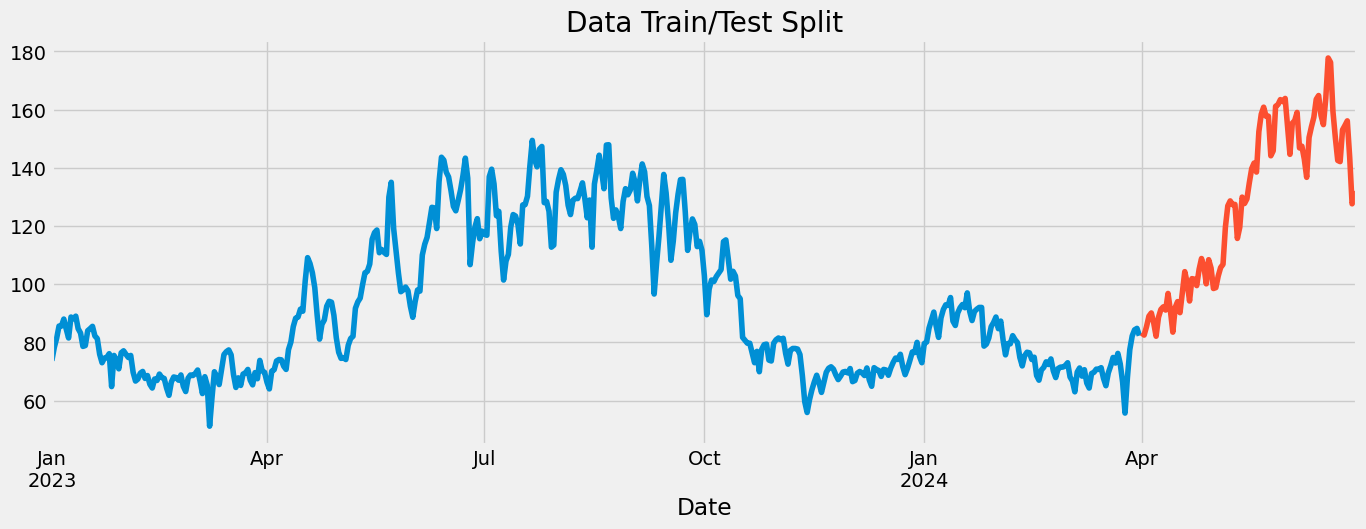

In [5]:
train = df.loc[df.index < '04-01-2024']
test = df.loc[df.index >= '04-01-2024']

fig, ax = plt.subplots(figsize=(15,5))
train['Energy Met (MU)'].plot(ax=ax, label='Train',title='Data Train/Test Split')
test['Energy Met (MU)'].plot(ax=ax, label='Test')


<Axes: xlabel='Date'>

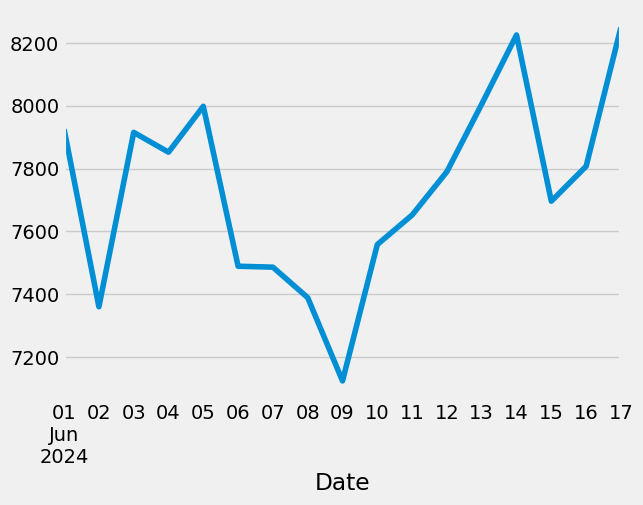

In [6]:
df['Un-Restricted Demand'].loc[(df.index >= '06-01-2024')  & (df.index <= '06-17-2024')].plot()

In [7]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize F/T Relationship

<Axes: xlabel='month', ylabel='Max Demand Met (MW)'>

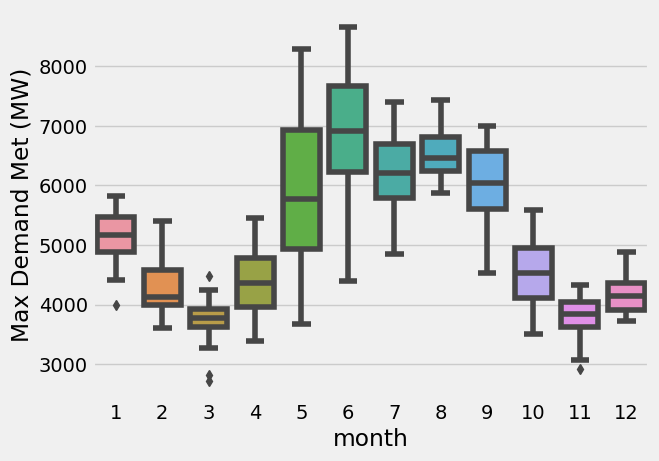

In [8]:
sns.boxplot(data=df,x='month',y = 'Max Demand Met (MW)')

<Axes: xlabel='month', ylabel='Energy Met (MU)'>

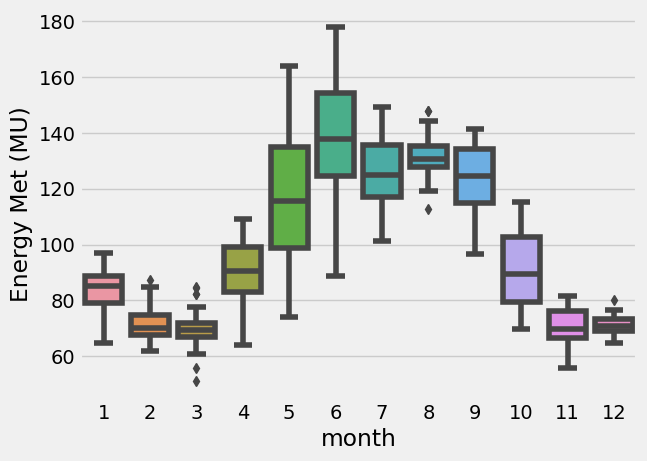

In [9]:
sns.boxplot(data=df,x='month',y = 'Energy Met (MU)')

# The Model

In [10]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'tempmax', 'tempmin', 'temp', 'feelslike', 'cloudcover','dew','humidity','solarenergy','quarter','month','year','dayofmonth','weekofyear']
TARGET = ['Un-Restricted Demand','Max Demand Met (MW)','Energy Met (MU)']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
# Initialize models for each target
reg_unrestricted = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, learning_rate=0.01)
reg_maxDemand = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, learning_rate=0.01)
reg_energyMet = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, learning_rate=0.01)

# Fit each model with its respective target
reg_unrestricted.fit(X_train, y_train['Un-Restricted Demand'],
                     eval_set=[(X_test, y_test['Un-Restricted Demand'])],
                     verbose=50)

reg_maxDemand.fit(X_train, y_train['Max Demand Met (MW)'],
                   eval_set=[(X_test, y_test['Max Demand Met (MW)'])],
                   verbose=50)

reg_energyMet.fit(X_train, y_train['Energy Met (MU)'],
                   eval_set=[(X_test, y_test['Energy Met (MU)'])],
                   verbose=50)


[0]	validation_0-rmse:2063.89150
[50]	validation_0-rmse:1571.38879
[100]	validation_0-rmse:1278.29792
[150]	validation_0-rmse:1096.19515
[200]	validation_0-rmse:989.16652
[250]	validation_0-rmse:917.55640
[300]	validation_0-rmse:867.00057
[350]	validation_0-rmse:833.20765
[400]	validation_0-rmse:811.57242
[450]	validation_0-rmse:798.44475
[499]	validation_0-rmse:791.24833
[0]	validation_0-rmse:2061.36956
[50]	validation_0-rmse:1568.84247
[100]	validation_0-rmse:1274.99168
[150]	validation_0-rmse:1094.78673
[200]	validation_0-rmse:985.43978
[250]	validation_0-rmse:911.57029
[300]	validation_0-rmse:863.36148
[350]	validation_0-rmse:830.21178
[400]	validation_0-rmse:809.72440
[450]	validation_0-rmse:796.77236
[499]	validation_0-rmse:789.11762
[0]	validation_0-rmse:45.22234
[50]	validation_0-rmse:34.25130
[100]	validation_0-rmse:27.11679
[150]	validation_0-rmse:23.29472
[200]	validation_0-rmse:21.15994
[250]	validation_0-rmse:19.83524
[300]	validation_0-rmse:18.87091
[350]	validation_0-rms

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Factors Importance

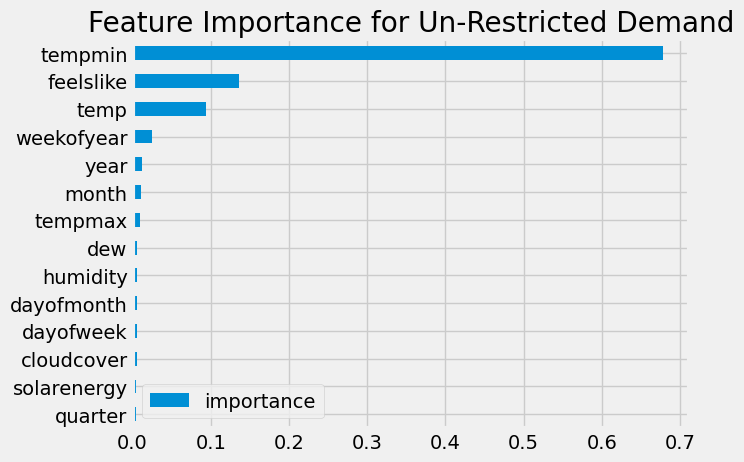

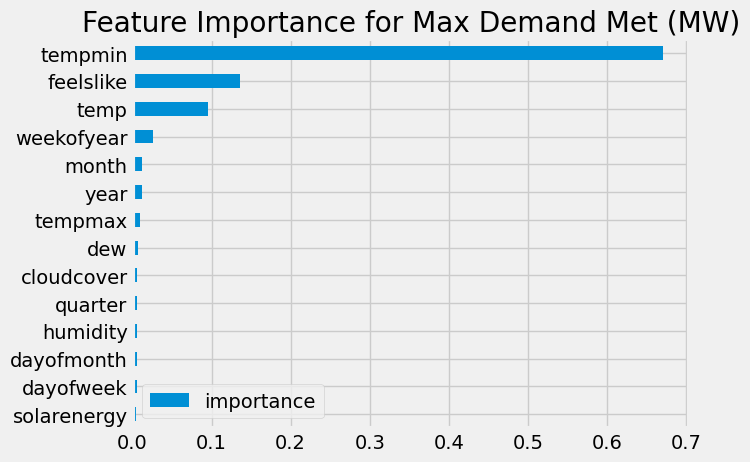

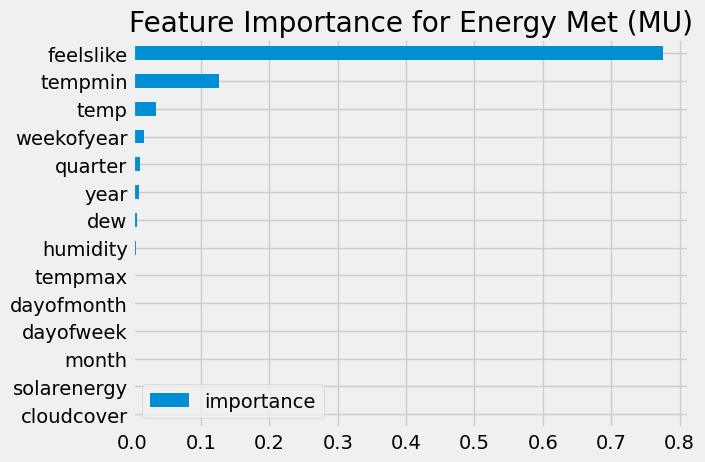

In [12]:
def plot_feature_importances(model, feature_names, title):
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=feature_names,
                      columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title=title)
    plt.show()

# Plot feature importances for each model
plot_feature_importances(reg_unrestricted, X_train.columns, 'Feature Importance for Un-Restricted Demand')
plot_feature_importances(reg_maxDemand, X_train.columns, 'Feature Importance for Max Demand Met (MW)')
plot_feature_importances(reg_energyMet, X_train.columns, 'Feature Importance for Energy Met (MU)')